<font size = "5"> **EELS_Tools:  [Spectroscopy](../4_EELS_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of EDS Spectra
<br>

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Spectroscopy/EDS.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Spectroscopy/EDS.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package



Notebook by Gerd Duscher, 2024

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## Content
An Introduction into displaying and analyzing EDS spectrum images and spectra
This works also on Google Colab.


## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [1]:
import sys
import importlib.metadata

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2024.02.0':
    print('installing pyTEMlib')
   
    !{sys.executable} -m pip install pyTEMlib -q --upgrade

# ------------------------------
print('done')

done


**In Google Colab: Please restart runtime Ctrl+M**

### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets.



In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

%load_ext autoreload
%autoreload 2
sys.path.insert(0,'../../../SciFiReaders/')
import SciFiReaders
print(SciFiReaders.__version__)
sys.path.insert(0,'../../')

import pyTEMlib
import pyTEMlib.file_tools     # File input/ output library
import pyTEMlib.eels_tools
import pyTEMlib.eds_tools

import scipy
import pyTEMlib.image_tools

if 'google.colab' in sys.modules:
    drive.mount("/content/drive")

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = '2_Image_Registration'
__notebook_version__ = '2024_6_28'

## Open File

### Load File

Select a main dataset and any additional data like reference data and such.

In [4]:
fileWidget = pyTEMlib.file_tools.FileWidget3()

### Select and Plot Dataset

Select a dataset from the drop down value and display it with the code cell below.

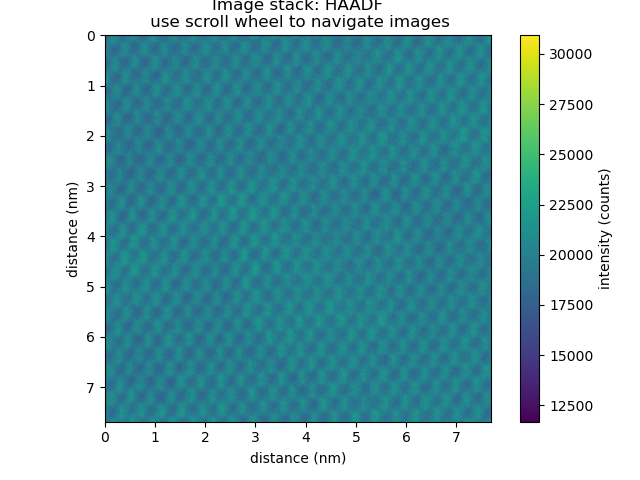

In [6]:
v = fileWidget.selected_dataset.plot()

sidpy.Dataset of type SPECTRAL_IMAGE with:
 dask.array<add, shape=(631, 223, 2048), dtype=uint16, chunksize=(631, 223, 2048), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
x:  distance (nm) of size (631,)
y:  distance (nm) of size (223,)
energy_scale:  energy (eV) of size (2048,)
 with metadata: ['experiment']

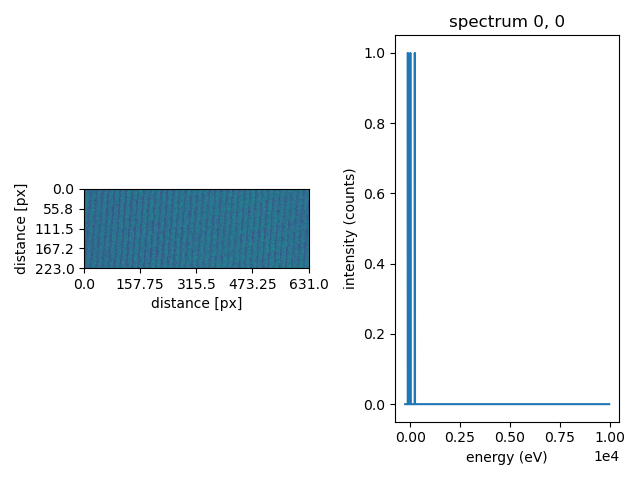

In [7]:
spectrum = None

for key in fileWidget.datasets.keys():
    if 'Super' in fileWidget.datasets[key].title:
        if spectrum == None:
            spectrum = fileWidget.datasets[key]
        else:
            spectrum += fileWidget.datasets[key]  
  
view = spectrum.plot()
spectrum


In [13]:
spectrum.data_type = 'spectral_image'
view = spectrum.sum(axis=[1]).plot()

NotImplementedError: Datasets with data_type DataType.SPECTRAL_IMAGE cannot be plotted, yet.

In [ ]:
start = 50
new_spectrum = scipy.ndimage.gaussian_filter(spectrum[start:], sigma=3)
new_energy_scale = spectrum.energy_scale[start:]
major_peaks, _  = scipy.signal.find_peaks(new_spectrum, prominence=40)  
minor_peaks, _  = scipy.signal.find_peaks(new_spectrum, prominence=3)  
minor_peaks = np.array(minor_peaks)+start
major_peaks = np.array(major_peaks)+start
plt.figure()
plt.plot(spectrum.energy_scale,spectrum, label = 'spectrum 1')
plt.plot(new_energy_scale, new_spectrum, label = 'filtered spectrum 1', color='black')

plt.scatter( spectrum.energy_scale[minor_peaks], spectrum[minor_peaks], color = 'red')
plt.scatter( spectrum.energy_scale[major_peaks], spectrum[major_peaks], color = 'orange')

In [ ]:
elements = pyTEMlib.eds_tools.find_elements(spectrum, np.array(minor_peaks))
print(elements)
spectrum.metadata['EDS'] = pyTEMlib.eds_tools.get_x_ray_lines(spectrum, elements)    
plt.figure()
plt.plot(spectrum.energy_scale,spectrum, label = 'spectrum')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())



In [ ]:
spectrum.metadata['EDS'] 

In [ ]:
spectrum.metadata['EDS'] = {}
spectrum.metadata['EDS']['detector'] = {}
elements[-1] = 'Sb'
elements += ['As']
print(elements)
pyTEMlib.eds_tools.get_x_ray_lines(spectrum, elements)
peaks, p = pyTEMlib.eds_tools.fit_model(spectrum, elements, use_detector_efficiency=False)
for key in spectrum.metadata['EDS']:
    print(f"{key}:")
    for family in spectrum.metadata['EDS'][key]:
        if 'family' in family:
            print(f"{family}:  {spectrum.metadata['EDS'][key][family]['areal_density']:.3f} atoms/nm^2" )

model = pyTEMlib.eds_tools.get_model(spectrum)

plt.figure()
plt.plot(spectrum.energy_scale, spectrum,  label='spectrum')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca()) 


plt.plot(spectrum.energy_scale, model, label='model')
plt.plot(spectrum.energy_scale, spectrum-model, label='residual')

plt.legend()




In [ ]:
pyTEMlib.eds_tools.get_eds_cross_sections(79)


In [ ]:
6915.004936267494 *0.011799/16, 5088.57172585567*0.015317/13, 6915.004936267494 *0.011799/ 5088.57172585567/0.015317


In [ ]:
144.5/16/7,  153.6376070726737/16.049676955798695/7


In [ ]:
5259.605 / 4536.087 , 4339.124 / 3337.746 

In [ ]:
3028.209 / 2392.879 , 2474.216 / 1894.291 

In [ ]:
spectrum.metadata['EDS']

In [ ]:
2100.835 , 5.689*36

In [ ]:
xs = pyTEMlib.eds_tools.get_eds_cross_sections(31) 
xs['L']/xs['K'], 18/13

In [ ]:
13

In [ ]:
spectrum.metadata['EDS']['Ga']['L-family']['areal_density']/19.2, (spectrum.metadata['EDS']['Ga']['K-family']['areal_density']/16.05)


In [ ]:
spectrum.metadata['EDS']['As']['L-family']['areal_density']/18.06 , (spectrum.metadata['EDS']['As']['K-family']['areal_density']/13.05)


In [ ]:
model = np.zeros(len(spectrum))
for i in range(len(p)-4):
    model += peaks[i]*p[i]
    pass

plt.figure()
plt.plot(spectrum.energy_scale, spectrum,  label='spectrum')
plt.plot(spectrum.energy_scale, model, label='model')
plt.plot(spectrum.energy_scale, spectrum-model, label='residual')
plt.legend()



In [ ]:
from pyTEMlib.xrpa_x_sections import x_sections
alpha_K = .9e6
alpha_L = 6.e7
alpha_M = 6*1e8 #  2.2e10
# omega_K = Z**4/(alpha_K+Z**4)
# omega_L = Z**4/(alpha_L+Z**4)
# omega_M = Z**4/(alpha_M+Z**4)
out_tags = {}
energy_scale = spectrum.get_spectral_dims(return_axis=True)[0].values
for element in elements:
    atomic_number = pyTEMlib.eds_tools.elements_list.index(element)
    out_tags[element] ={'Z': atomic_number}
    if 'K-L3' in x_sections[str(atomic_number)]['lines']:
        if x_sections[str(atomic_number)]['lines']['K-L3']['position'] < energy_scale[-1]:
            height = spectrum[np.searchsorted(energy_scale, x_sections[str(atomic_number)]['lines']['K-L3']['position'] )]
            out_tags[element]['K-family'] = {'height': height}
            if 'K' in x_sections[str(atomic_number)]['fluorescent_yield']:
                out_tags[element]['K-family']['yield'] = x_sections[str(atomic_number)]['fluorescent_yield']['K']
            else:
                out_tags[element]['K-family']['yield'] = atomic_number**4/(alpha_K+atomic_number**4)/4/1.4
out_tags

In [ ]:
from numba import jit

# @jit(nopython = False)
def get_array(data, xv, yv, z_length):
    profile = np.zeros([xv.shape[1], 2, z_length], dtype='float')
        
    for index_x in range(xv.shape[1]):
        for  index_y  in range(xv.shape[0]):
            x = int(xv[index_y, index_x])
            y = int(yv[index_y, index_x])
            if x< data.shape[0] and x>0 and y < data.shape[1] and y>0:
                profile[index_x, 0] +=data[x, y]
    return profile


def get_profile(dataset, line):
    xv, yv = get_line_selection_points(line)
    
    if dataset.data_type.name == 'IMAGE':
        dataset.get_image_dims()
        profile = scipy.ndimage.map_coordinates(np.array(dataset.T), [xv,yv])
        
        profile_dataset = sidpy.Dataset.from_array(profile.sum(axis=0))
        profile_dataset.data_type='spectrum'
        profile_dataset.units = dataset.units
        profile_dataset.quantity = dataset.quantity
        profile_dataset.set_dimension(0, sidpy.Dimension(np.linspace(xv[0,0], xv[-1,-1], profile_dataset.shape[0]), 
                                                  name='x', units=dataset.x.units, quantity=dataset.x.quantity,
                                                  dimension_type='spatial'))

        profile_dataset

    if dataset.data_type.name == 'SPECTRAL_IMAGE':
        spectral_axis = dataset.get_spectral_dims(return_axis=True)[0]
        profile = get_array(np.array(dataset), xv, yv, dataset.shape[2])

        profile_dataset = sidpy.Dataset.from_array(profile)
        profile_dataset.data_type='spectral_image'
        profile_dataset.units = dataset.units
        profile_dataset.quantity = dataset.quantity
        profile_dataset.set_dimension(0, sidpy.Dimension(np.linspace(xv[0,0], xv[-1,-1], profile_dataset.shape[0]), 
                                                  name='x', units=dataset.x.units, quantity=dataset.x.quantity,
                                                  dimension_type='spatial'))
        profile_dataset.set_dimension(2, spectral_axis)
    return profile_dataset

def get_line_selection_points(line):
    
    start_point = line.line_verts[3]
    right_point = line.line_verts[0]
    low_point = line.line_verts[2]

    if start_point[0] > right_point[0]:
        start_point = line.line_verts[0]
        right_point = line.line_verts[3]
        low_point = line.line_verts[1]
    m = (right_point[1] - start_point[1]) / (right_point[0] - start_point[0])
    length_x = int(abs(start_point[0]-right_point[0]))
    length_v = int(np.linalg.norm(start_point-right_point))
    
    linewidth = int(abs(start_point[1]-low_point[1]))
    x = np.linspace(0,length_x, length_v)
    y = np.linspace(0,linewidth, line.line_width)
    xv, yv = np.meshgrid(x, y)
    
    yy = yv +x*m+start_point[1] 
    xx = (xv.T -y*m ).T + start_point[0]
    
    return xx, yy



def select(b):
    pass

In [ ]:
v = d.plot()
selected_area = pyTEMlib.image_tools.LineSelector(v.axes[0], select, 100)

In [ ]:
selected_area.set_linewidth(100)

In [ ]:
dataset.original_metadata

In [ ]:
dataset.metadata['experiment']
tags = dataset.metadata['experiment']
tags['acceleration_voltage_V'] = tags['acceleration_voltage']
tags['microscope']['acceleration_voltage']

In [ ]:
tags = dataset.metadata['experiment']
spectrum = dataset
spectrum.metadata = dataset.metadata
tags['acceleration_voltage_V'] = float(tags['acceleration_voltage'])
print(tags['acceleration_voltage_V'])
start = np.searchsorted(spectrum.energy_scale, 150)
detector_efficiency = np.zeros(len(spectrum))
detector_efficiency+= pyTEMlib.eds_tools.detector_response(spectrum)
plt.figure()
plt.plot(spectrum.energy_scale, detector_efficiency), 

## Fit Spectrum


In [ ]:
#elements = ['C', 'O', 'Cu',  'Al',  'Ni', 'Zn', 'Mn', 'Ce', 'Mg']

# spectrum.metadata = chooser.dataset.metadata
spectrum.metadata['EDS'] = {}
pyTEMlib.eds_tools.get_x_ray_lines(spectrum, elements)
peaks, p = pyTEMlib.eds_tools.fit_model(spectrum, elements, use_detector_efficiency= False)



In [ ]:

results = {}
from tqdm.notebook import trange, tqdm
for i in trange(len(prof[:,0])):
    spectrum = prof[i, 0]
    spectrum.metadata = chooser.dataset.metadata
    spectrum.metadata['EDS'] = {}
    peaks, p = pyTEMlib.eds_tools.fit_model(spectrum, elements, use_detector_efficiency= True)
    for element in chooser.dataset.metadata['EDS']['lines'].keys():
        for family in chooser.dataset.metadata['EDS']['lines'][element].keys():
            if family !='Z':
                if 'height' in chooser.dataset.metadata['EDS']['lines'][element][family].keys():
                    if element+': '+family not in results:
                        results[element+': '+family] = []
                    results[element+': '+family].append(chooser.dataset.metadata['EDS']['lines'][element][family]['height'])
                else: 
                    for line in  chooser.dataset.metadata['EDS']['lines'][element][family]:
                        if element+': '+line not in results:
                            results[element+': '+line] = []
                        results[element+': '+line].append(chooser.dataset.metadata['EDS']['lines'][element][family][line]['height'])
    

model = np.zeros(len(spectrum))
for i in range(len(p)-4):
    model += peaks[i]*p[i]
    pass
start = np.searchsorted(spectrum.energy_scale, 150)
energy_scale = spectrum.energy_scale[start:]
#p[-3:] = [100, 3, .007]
print(p[-4:])
E_0 = spectrum.metadata['experiment']['acceleration_voltage_V'][0]

#model[start:] += (detector_efficiency[start:] * (p[-3] + p[-2] * (E_0 - energy_scale) / energy_scale + p[-1] * (E_0-energy_scale) ** 2 / energy_scale))
bgd = p[-4] / (energy_scale + p[-3] * energy_scale ** 2 + p[-2] * energy_scale ** .5) - p[-1]

model[start:] += detector_efficiency[start:] * bgd
            
plt.figure()
plt.plot(spectrum.energy_scale, spectrum, label='spectrum')

plt.plot(spectrum.energy_scale,model, label='model')
# plt.plot(spectrum.energy_scale[start:], bgd*detector_efficiency[start:])
plt.plot(spectrum.energy_scale,spectrum-model,  label='difference')
plt.ylim(0, 400)
p[:-4], E_0

In [ ]:
for element in chooser.dataset.metadata['EDS']['lines'].keys():
    for family in chooser.dataset.metadata['EDS']['lines'][element].keys():
        if family !='Z':
            if 'height' in chooser.dataset.metadata['EDS']['lines'][element][family].keys():
                print(element, family, chooser.dataset.metadata['EDS']['lines'][element][family]['height'])
            else: 
                for line in  chooser.dataset.metadata['EDS']['lines'][element][family]:
                    print(element, line, chooser.dataset.metadata['EDS']['lines'][element][family][line]['height'])

In [ ]:
print(results.keys())
plt.figure()
for key in ['C: K-L2',   'Cu: K-family', 'Ni: K-family',  'Zn: K-family', 'O: K-family', 'Mn: L-family', 'Mg: K-family']:
    plt.plot(results[key], label=key)
plt.legend()
len(p)

In [ ]:
print(results.keys())
plt.figure()
for key in ['Cu: K-family', 'Ni: K-family', 'Mn: L-family']:
    plt.plot(results[key], label=key)
plt.legend()
len(p)

In [ ]:
plt.figure()
for key in ['Ce: L-family', 'Ce: M-family', 'Al: K-family', 'Mn: L-family', 'Mg: K-family']:
    plt.plot(results[key], label=key)
plt.legend()

In [ ]:
plot.close('all')

In [ ]:
pyTEMlib.eds_tools.get_phases(chooser.dataset, number_of_phases=5)
fig = pyTEMlib.eds_tools.plot_phases(chooser.dataset, image_chooser.dataset, survey_image_chooser.dataset)

## Spectrum Image
Select the HAADF image reference

In [ ]:

# elements = pyTEMlib.eds_tools.find_elements(spectrum, minor_peaks)
